# 參考資源

- [利用Keras建構LSTM模型，以Stock Prediction 為例 1 ->> 下面的code，大部份是從這個medium post抄來的](https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b)

- [Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model](https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f)

- [How to Use the **TimeDistributed** Layer in Keras](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)

- [Keras 中 LSTM 层两个重要参数理解](https://huhuhang.com/post/machine-learning/lstm-return-sequences-state)

- [How to use **return_state** or **return_sequences** in Keras](https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/)

# LSTM知識點

- 建構要求的訓練資料結構
- `return_sequence`的應用
- `TimeDistributed`的應用
- LSTM追縱過去的趨勢，不一定能用在外在環境改變下的新趨勢
- auto-correlation的問題，還有傳統時間序列模型的優勢

# 匯入所需的套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Activation, 
                                     Flatten, LSTM, TimeDistributed, RepeatVector)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

%matplotlib inline

# 讀取資料

In [3]:
def readTrain(filePath):
    train = pd.read_csv(filePath)
    return train

filePath = "./VTI_train_2000_2018.csv"
train = readTrain(filePath)

In [4]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-06-15,55.424999,56.005001,55.174999,55.665001,38.975655,1067400
1,2001-06-18,55.814999,55.915001,55.310001,55.310001,38.727097,282600
2,2001-06-19,56.150002,56.165001,55.235001,55.465000,38.835609,1777600
3,2001-06-20,55.375000,56.075001,55.375000,56.049999,39.245239,476000
4,2001-06-21,56.000000,56.724998,55.875000,56.500000,39.560299,240400


# Augment Features

In [5]:
def augFeatures(train):
    train["Date"] = pd.to_datetime(train["Date"])
    train["year"] = train["Date"].dt.year
    train["month"] = train["Date"].dt.month
    train["date"] = train["Date"].dt.day
    train["day"] = train["Date"].dt.dayofweek
    train = train.drop(["Date"], axis=1)
    return train

train = augFeatures(train)

In [6]:
train.head()

,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,55.424999,56.005001,55.174999,55.665001,38.975655,1067400,2001,6,15,4
1,55.814999,55.915001,55.310001,55.310001,38.727097,282600,2001,6,18,0
2,56.150002,56.165001,55.235001,55.465000,38.835609,1777600,2001,6,19,1
3,55.375000,56.075001,55.375000,56.049999,39.245239,476000,2001,6,20,2
4,56.000000,56.724998,55.875000,56.500000,39.560299,240400,2001,6,21,3


In [7]:
# rename cols
train.columns = [
    "open", "high", "low", "close", "adj_close", "vol", "year", "month",
    "date", "day"
]

In [8]:
# reindex, 將target value移到最後一個欄位
train = train.reindex(columns=[
    "open", "high", "low", "close", "vol", "year", "month",
    "date", "day", "adj_close"
])

In [9]:
train.head()

,open,high,low,close,vol,year,month,date,day,adj_close
0,55.424999,56.005001,55.174999,55.665001,1067400,2001,6,15,4,38.975655
1,55.814999,55.915001,55.310001,55.310001,282600,2001,6,18,0,38.727097
2,56.150002,56.165001,55.235001,55.465000,1777600,2001,6,19,1,38.835609
3,55.375000,56.075001,55.375000,56.049999,476000,2001,6,20,2,39.245239
4,56.000000,56.724998,55.875000,56.500000,240400,2001,6,21,3,39.560299


# Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler 

def normalize(train):
    scaler = MinMaxScaler()
    train_norm = scaler.fit_transform(train)
    return train_norm, scaler

train_norm, scaler = normalize(train)

# Build Train Data

In [11]:
def buildTrain(train, pastDay=30, futureDay=5):
    x, y = [], []
    for i in range(0, (train.shape[0] - futureDay - pastDay), futureDay):
        x.append(np.array(train[i:i + pastDay]))
        y.append(np.array(train[(i + pastDay):(i + pastDay + futureDay), -1]))
    return np.array(x), np.array(y)

x, y = buildTrain(train_norm)

# 資料亂序

In [12]:
from sklearn.utils import shuffle

def dataShuffle(x, y):
    x, y = shuffle(x,y, random_state=2)
    return x, y

x, y = dataShuffle(x, y)

# Train/Valid/Test Split

In [13]:
def splitData(x, y, splitInterval=(0.5, 0.7)):
    size = x.shape[0]
    A, B = splitInterval
    x_train, y_train = x[:int(size * A), ...], y[:int(size * A), :]
    x_val, y_val = x[int(size * A):int(size * B), ...], \
                   y[int(size * A):int(size * B), :]
    x_test, y_test = x[int(size * B):, ...], y[int(size * B):, :]
    return x_train, x_val, x_test, y_train, y_val, y_test

In [14]:
x_train, x_val, x_test, y_train, y_val, y_test = splitData(x, y)

# 查看各個資料集Size是否正確

In [15]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (438, 30, 10)
y_train shape:  (438, 5)
x_val shape:  (175, 30, 10)
y_val shape:  (175, 5)
x_test shape:  (263, 30, 10)
y_test shape:  (263, 5)


# Build Many to Many Model

In [16]:
def buildMtoM(x_train, target_num=5, lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(
        LSTM(units=128,
             input_shape=(x_train.shape[1], x_train.shape[2]),
             activation="relu",
             return_sequences=True))
    model.add(Dropout(rate=0.3))
    model.add(LSTM(units=64,activation="relu", return_sequences=False))
    model.add(Dense(units=target_num))
    opt = Adam(lr=lr, decay=decay)
    model.compile(loss="mse", optimizer=opt)
    model.summary()
    return model

model = buildMtoM(x_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           71168     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 120,901
Trainable params: 120,901
Non-trainable params: 0
_________________________________________________________________


# 定義Callbacks

In [17]:
early_stop = EarlyStopping(monitor="val_loss",
                           patience=5,
                           verbose=1,
                           restore_best_weights=True)

checkpoint_dir = "./checkpoint/"
model_ckpt = ModelCheckpoint(filepath=checkpoint_dir + "{epoch}-{loss:.6f}-modelckpt.h5",
                             monitor="val_loss",
                             save_best_only=True,
                             verbose=1,
                             save_freq="epoch")

# 開始訓練模型

In [18]:
EPOCHS = 50
BATCH_SIZE = 32

H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_val, y_val),
              callbacks=[early_stop, model_ckpt])

Train on 438 samples, validate on 175 samples
Epoch 1/50
416/438 [===========================>..] - ETA: 0s - loss: 0.0706
Epoch 00001: val_loss improved from inf to 0.00965, saving model to ./checkpoint/1-0.067350-modelckpt.h5
438/438 [==============================] - 4s 9ms/sample - loss: 0.0674 - val_loss: 0.0097
Epoch 2/50
384/438 [=========================>....] - ETA: 0s - loss: 0.0080
Epoch 00002: val_loss improved from 0.00965 to 0.00230, saving model to ./checkpoint/2-0.007273-modelckpt.h5
438/438 [==============================] - 1s 2ms/sample - loss: 0.0073 - val_loss: 0.0023
Epoch 3/50
416/438 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 00003: val_loss improved from 0.00230 to 0.00162, saving model to ./checkpoint/3-0.002199-modelckpt.h5
438/438 [==============================] - 1s 2ms/sample - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
384/438 [=========================>....] - ETA: 0s - loss: 0.0014
Epoch 00004: val_loss improved from 0.00162 to 0.0

# 訓練紀錄

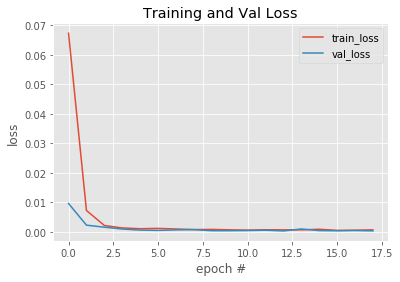

In [19]:
plt.style.use("ggplot")
plt.figure()
N = len(H.history["loss"])
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.title("Training and Val Loss")
plt.legend(loc="best")
plt.show()

# 在測試集的表現

In [20]:
y_preds = model.predict(x_test)

In [21]:
y_preds.shape

(263, 5)

In [22]:
y_test.shape

(263, 5)

In [23]:
test_loss = mean_squared_error(y_test, y_preds)
test_loss

0.00032439157072752193

# 在原資料上的預測

In [26]:
def predict_plot(model, buildTrain, df):
    x, y = buildTrain(df)
    y_ = model.predict(x)
    
    y = y.reshape(-1,)
    y_ = y_.reshape(-1,)
    
    plt.figure()
    plt.plot(np.arange(0, len(y)), y, label="real_y")
    plt.plot(np.arange(0, len(y_)), y_, label="pred_y")
    plt.title("Real vs Predicted Y (re-scaled)")
    plt.legend(loc="best")
    plt.show()

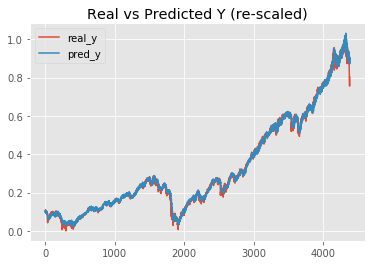

In [27]:
predict_plot(model, buildTrain, train_norm)

# 在新資料上的預測

In [28]:
filePath = "./VTI_test_2019_2020.csv"
test = readTrain(filePath)

In [29]:
test = augFeatures(test)

In [30]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,125.750000,128.160004,125.339996,127.730003,124.131165,5093200,2019,1,2,2
1,126.910004,126.910004,124.570000,124.769997,121.254555,5252900,2019,1,3,3
2,126.480003,129.369995,126.320000,128.899994,125.268188,4776900,2019,1,4,4
3,129.190002,131.039993,128.809998,130.199997,126.531570,4485100,2019,1,7,0
4,131.449997,131.729996,130.050003,131.539993,127.833801,3949400,2019,1,8,1


In [31]:
# rename cols
test.columns = [
    "open", "high", "low", "close", "adj_close", "vol", "year", "month",
    "date", "day"
]

In [32]:
# reindex, 將target value移到最後一個欄位
test = test.reindex(columns=[
    "open", "high", "low", "close", "vol", "year", "month",
    "date", "day", "adj_close"
])

In [33]:
test.head()

,open,high,low,close,vol,year,month,date,day,adj_close
0,125.750000,128.160004,125.339996,127.730003,5093200,2019,1,2,2,124.131165
1,126.910004,126.910004,124.570000,124.769997,5252900,2019,1,3,3,121.254555
2,126.480003,129.369995,126.320000,128.899994,4776900,2019,1,4,4,125.268188
3,129.190002,131.039993,128.809998,130.199997,4485100,2019,1,7,0,126.531570
4,131.449997,131.729996,130.050003,131.539993,3949400,2019,1,8,1,127.833801


In [34]:
test_norm = scaler.transform(test)

In [35]:
test_norm[:5]

array([[0.77934824, 0.79784879, 0.78802864, 0.79950688, 0.12011933,
        1.05882353, 0.        , 0.03333333, 0.5       , 0.82125065],
       [0.7891663 , 0.7871778 , 0.78168025, 0.7743389 , 0.12389433,
        1.05882353, 0.        , 0.06666667, 0.75      , 0.79718095],
       [0.78552686, 0.80817823, 0.79610848, 0.80945494, 0.1126426 ,
        1.05882353, 0.        , 0.1       , 1.        , 0.83076457],
       [0.80846379, 0.82243466, 0.81663777, 0.82050845, 0.105745  ,
        1.05882353, 0.        , 0.2       , 0.        , 0.84133577],
       [0.82759197, 0.82832507, 0.82686125, 0.831902  , 0.09308208,
        1.05882353, 0.        , 0.23333333, 0.25      , 0.85223204]])

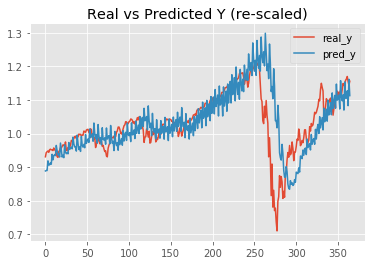

In [36]:
predict_plot(model, buildTrain, test_norm)

# 結論

可以看到，LSTM模型基本上變成是跟隨著前一期的資料走(可以假想一個狀況，就是模型拿上一期的資料，當作這一期的預測點)，這是因為針對時間序列，每個時間點的資料，都會auto-correlated，所以針對時間序列的資料，其實使用傳統的time series模型，可能會比較洽當。